### Import the libraries

In [3]:
!pip install "numpy<2.0" --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [3]:
# reinstall scanpy
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 43.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.1 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [scanpy]━━  9/10 [scanpy]]els]


In [77]:

# standard libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import scanpy as sc
from scipy.sparse import csr_matrix

# Visualize latent space
import matplotlib.pyplot as plt
import seaborn as sns

# add time stamp
import os
from pathlib import Path

from datetime import datetime

# data loader
from torch.utils.data import DataLoader
from tqdm import tqdm


### Change working directory

In [80]:
# go to current directory
%cd /home/ubuntu/anatoly-tahoe-100-texas/code/tahoe-100m

/home/ubuntu/anatoly-tahoe-100-texas/code/tahoe-100m


### Create time stamps

In [83]:

# Create checkpoint directory with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_dir = f'models'
os.makedirs(checkpoint_dir, exist_ok=True)


### Import the data

In [3]:

adata_100m=sc.read_h5ad("/home/ubuntu/anatoly-tahoe-100-texas/data/tahoe-100m_5M.h5ad")


/home/ubuntu/miniconda3/envs/torch-gpu/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Normalize the data

In [4]:

# Normalize each cell to 10,000 counts (CPM-like)
sc.pp.normalize_total(adata_100m, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata_100m)


### HVG selection (start with small subset)

In [15]:

# Step 2: Identify highly variable genes
sc.pp.highly_variable_genes(adata_100m, n_top_genes=2000, subset=True, flavor="seurat")


### Train and test data split

In [17]:

# get train and test idx
train_idx, test_idx = train_test_split(adata_100m.obs.index, test_size=0.1, random_state=42)

# data split with copy
adata_train = adata_100m[train_idx].copy()
adata_test = adata_100m[test_idx].copy()

### Dataset class

In [19]:

class AdataCVAEWrapper(Dataset):
    def __init__(self, adata, cat_features, cont_features):
        self.X = adata.X  # keep expression data as sparse matrix
        self.cat_data = pd.get_dummies(adata.obs[cat_features], drop_first=False).values.astype(np.float32)
        self.cat_data = torch.from_numpy(self.cat_data)

        cont = adata.obs[cont_features].values.astype(np.float32)
        cont = (cont - cont.mean(axis=0)) / cont.std(axis=0)
        self.cont_data = torch.from_numpy(cont)

        self.cond = torch.cat([self.cat_data, self.cont_data], dim=1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_row = torch.tensor(self.X[idx].toarray().squeeze(), dtype=torch.float32)
        c = self.cond[idx]
        return x_row, c
    

### Neural network class

In [105]:
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.ReLU()  # or identity / Sigmoid depending on your output
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

### Loss function

In [106]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

### Prepare the data

In [107]:

# setup features
cat_features=["drug", "cell_line_id"]
cont_features=["drug_conc"]

# create train and test datasets
train_dataset = AdataCVAEWrapper(adata_train, cat_features, cont_features)
test_dataset = AdataCVAEWrapper(adata_test, cat_features, cont_features)

# create train and test loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


In [108]:

# setup the model
model = CVAE(input_dim=adata_train.shape[1], cond_dim=train_dataset.cond.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=2146, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=166, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=2000, bias=True)
    (6): ReLU()
  )
)

### Setup parameters and create validation dataset

In [109]:
# Create validation set from training data
train_idx, val_idx = train_test_split(adata_train.obs.index, test_size=0.1, random_state=42)
adata_val = adata_train[val_idx].copy()

# create validation dataset
val_dataset = AdataCVAEWrapper(adata_val, cat_features, cont_features)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)


### Train the model for 100 of epochs

In [110]:
# Save training configuration

n_epochs = 200

# no early stopping
patience = 999

config = {
    'input_dim': adata_train.shape[1],
    'latent_dim': 32,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'n_epochs': n_epochs,
    'patience': patience,
    'timestamp': timestamp
}

with open(f'{checkpoint_dir}/config.txt', 'w') as f:
    for key, value in config.items():
        f.write(f'{key}: {value}\n')

In [111]:
# Training loop
for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for x_batch, c_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}'):
        x_batch = x_batch.to(device)
        c_batch = c_batch.to(device)

        recon_x, mu, logvar = model(x_batch, c_batch)
        loss = loss_function(recon_x, x_batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, c_batch in val_loader:
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)
            
            recon_x, mu, logvar = model(x_batch, c_batch)
            loss = loss_function(recon_x, x_batch, mu, logvar)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(checkpoint, f'{checkpoint_dir}/best_model.pth')
        print(f'New best model saved with validation loss: {best_val_loss:.2f}')
    else:
        patience_counter += 1
    
    # Save latest checkpoint
    torch.save(checkpoint, f'{checkpoint_dir}/latest_model.pth')
    
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train Loss: {avg_train_loss:.2f}')
    print(f'  Val Loss: {avg_val_loss:.2f}')
    print(f'  Best Val Loss: {best_val_loss:.2f}')
    print(f'  Patience Counter: {patience_counter}/{patience}')
    
    # early stopping if patience is reached
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

Epoch 1/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.74it/s]


Epoch 1/200:
  Train Loss: 29528.26
  Val Loss: 28687.62
  Best Val Loss: 27374.40
  Patience Counter: 11/999


Epoch 2/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.81it/s]


Epoch 2/200:
  Train Loss: 28588.74
  Val Loss: 28308.90
  Best Val Loss: 27374.40
  Patience Counter: 12/999


Epoch 3/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.28it/s]


Epoch 3/200:
  Train Loss: 28390.08
  Val Loss: 28201.62
  Best Val Loss: 27374.40
  Patience Counter: 13/999


Epoch 4/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.58it/s]


Epoch 4/200:
  Train Loss: 28295.13
  Val Loss: 28122.30
  Best Val Loss: 27374.40
  Patience Counter: 14/999


Epoch 5/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.99it/s]


Epoch 5/200:
  Train Loss: 28231.08
  Val Loss: 28056.03
  Best Val Loss: 27374.40
  Patience Counter: 15/999


Epoch 6/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.19it/s]


Epoch 6/200:
  Train Loss: 28174.11
  Val Loss: 28001.02
  Best Val Loss: 27374.40
  Patience Counter: 16/999


Epoch 7/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.53it/s]


Epoch 7/200:
  Train Loss: 28109.33
  Val Loss: 27945.39
  Best Val Loss: 27374.40
  Patience Counter: 17/999


Epoch 8/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.63it/s]


Epoch 8/200:
  Train Loss: 28071.96
  Val Loss: 27911.29
  Best Val Loss: 27374.40
  Patience Counter: 18/999


Epoch 9/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.22it/s]


Epoch 9/200:
  Train Loss: 28045.98
  Val Loss: 27887.17
  Best Val Loss: 27374.40
  Patience Counter: 19/999


Epoch 10/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.00it/s]


Epoch 10/200:
  Train Loss: 28022.83
  Val Loss: 27865.37
  Best Val Loss: 27374.40
  Patience Counter: 20/999


Epoch 11/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.84it/s]


Epoch 11/200:
  Train Loss: 28004.76
  Val Loss: 27848.13
  Best Val Loss: 27374.40
  Patience Counter: 21/999


Epoch 12/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.13it/s]


Epoch 12/200:
  Train Loss: 27987.09
  Val Loss: 27823.52
  Best Val Loss: 27374.40
  Patience Counter: 22/999


Epoch 13/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.63it/s]


Epoch 13/200:
  Train Loss: 27969.03
  Val Loss: 27822.96
  Best Val Loss: 27374.40
  Patience Counter: 23/999


Epoch 14/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.66it/s]


Epoch 14/200:
  Train Loss: 27956.31
  Val Loss: 27796.73
  Best Val Loss: 27374.40
  Patience Counter: 24/999


Epoch 15/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.18it/s]


Epoch 15/200:
  Train Loss: 27944.17
  Val Loss: 27786.58
  Best Val Loss: 27374.40
  Patience Counter: 25/999


Epoch 16/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.52it/s]


Epoch 16/200:
  Train Loss: 27932.54
  Val Loss: 27778.22
  Best Val Loss: 27374.40
  Patience Counter: 26/999


Epoch 17/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.25it/s]


Epoch 17/200:
  Train Loss: 27922.53
  Val Loss: 27766.13
  Best Val Loss: 27374.40
  Patience Counter: 27/999


Epoch 18/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.67it/s]


Epoch 18/200:
  Train Loss: 27911.79
  Val Loss: 27760.31
  Best Val Loss: 27374.40
  Patience Counter: 28/999


Epoch 19/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.30it/s]


Epoch 19/200:
  Train Loss: 27902.74
  Val Loss: 27751.96
  Best Val Loss: 27374.40
  Patience Counter: 29/999


Epoch 20/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.97it/s]


Epoch 20/200:
  Train Loss: 27893.48
  Val Loss: 27737.49
  Best Val Loss: 27374.40
  Patience Counter: 30/999


Epoch 21/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.30it/s]


Epoch 21/200:
  Train Loss: 27886.48
  Val Loss: 27736.89
  Best Val Loss: 27374.40
  Patience Counter: 31/999


Epoch 22/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.99it/s]


Epoch 22/200:
  Train Loss: 27877.99
  Val Loss: 27728.19
  Best Val Loss: 27374.40
  Patience Counter: 32/999


Epoch 23/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.22it/s]


Epoch 23/200:
  Train Loss: 27870.79
  Val Loss: 27713.37
  Best Val Loss: 27374.40
  Patience Counter: 33/999


Epoch 24/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.59it/s]


Epoch 24/200:
  Train Loss: 27864.55
  Val Loss: 27719.52
  Best Val Loss: 27374.40
  Patience Counter: 34/999


Epoch 25/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.35it/s]


Epoch 25/200:
  Train Loss: 27858.84
  Val Loss: 27708.19
  Best Val Loss: 27374.40
  Patience Counter: 35/999


Epoch 26/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.40it/s]


Epoch 26/200:
  Train Loss: 27853.01
  Val Loss: 27697.71
  Best Val Loss: 27374.40
  Patience Counter: 36/999


Epoch 27/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.29it/s]


Epoch 27/200:
  Train Loss: 27848.15
  Val Loss: 27691.61
  Best Val Loss: 27374.40
  Patience Counter: 37/999


Epoch 28/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.56it/s]


Epoch 28/200:
  Train Loss: 27843.15
  Val Loss: 27690.75
  Best Val Loss: 27374.40
  Patience Counter: 38/999


Epoch 29/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.57it/s]


Epoch 29/200:
  Train Loss: 27838.77
  Val Loss: 27685.48
  Best Val Loss: 27374.40
  Patience Counter: 39/999


Epoch 30/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.30it/s]


Epoch 30/200:
  Train Loss: 27833.63
  Val Loss: 27678.05
  Best Val Loss: 27374.40
  Patience Counter: 40/999


Epoch 31/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.41it/s]


Epoch 31/200:
  Train Loss: 27831.22
  Val Loss: 27686.49
  Best Val Loss: 27374.40
  Patience Counter: 41/999


Epoch 32/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.61it/s]


Epoch 32/200:
  Train Loss: 27825.79
  Val Loss: 27678.31
  Best Val Loss: 27374.40
  Patience Counter: 42/999


Epoch 33/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.21it/s]


Epoch 33/200:
  Train Loss: 27821.78
  Val Loss: 27671.07
  Best Val Loss: 27374.40
  Patience Counter: 43/999


Epoch 34/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 125.98it/s]


Epoch 34/200:
  Train Loss: 27819.08
  Val Loss: 27666.21
  Best Val Loss: 27374.40
  Patience Counter: 44/999


Epoch 35/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.33it/s]


Epoch 35/200:
  Train Loss: 27815.83
  Val Loss: 27663.38
  Best Val Loss: 27374.40
  Patience Counter: 45/999


Epoch 36/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.27it/s]


Epoch 36/200:
  Train Loss: 27811.28
  Val Loss: 27655.54
  Best Val Loss: 27374.40
  Patience Counter: 46/999


Epoch 37/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.22it/s]


Epoch 37/200:
  Train Loss: 27806.64
  Val Loss: 27658.19
  Best Val Loss: 27374.40
  Patience Counter: 47/999


Epoch 38/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.00it/s]


Epoch 38/200:
  Train Loss: 27804.70
  Val Loss: 27648.68
  Best Val Loss: 27374.40
  Patience Counter: 48/999


Epoch 39/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.76it/s]


Epoch 39/200:
  Train Loss: 27799.53
  Val Loss: 27641.36
  Best Val Loss: 27374.40
  Patience Counter: 49/999


Epoch 40/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.16it/s]


Epoch 40/200:
  Train Loss: 27797.18
  Val Loss: 27641.53
  Best Val Loss: 27374.40
  Patience Counter: 50/999


Epoch 41/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.07it/s]


Epoch 41/200:
  Train Loss: 27792.78
  Val Loss: 27638.98
  Best Val Loss: 27374.40
  Patience Counter: 51/999


Epoch 42/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.60it/s]


Epoch 42/200:
  Train Loss: 27788.18
  Val Loss: 27638.84
  Best Val Loss: 27374.40
  Patience Counter: 52/999


Epoch 43/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.42it/s]


Epoch 43/200:
  Train Loss: 27786.55
  Val Loss: 27635.62
  Best Val Loss: 27374.40
  Patience Counter: 53/999


Epoch 44/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.45it/s]


Epoch 44/200:
  Train Loss: 27783.88
  Val Loss: 27629.84
  Best Val Loss: 27374.40
  Patience Counter: 54/999


Epoch 45/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.78it/s]


Epoch 45/200:
  Train Loss: 27780.31
  Val Loss: 27621.57
  Best Val Loss: 27374.40
  Patience Counter: 55/999


Epoch 46/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.12it/s]


Epoch 46/200:
  Train Loss: 27776.23
  Val Loss: 27623.20
  Best Val Loss: 27374.40
  Patience Counter: 56/999


Epoch 47/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.45it/s]


Epoch 47/200:
  Train Loss: 27774.20
  Val Loss: 27619.41
  Best Val Loss: 27374.40
  Patience Counter: 57/999


Epoch 48/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.07it/s]


Epoch 48/200:
  Train Loss: 27772.49
  Val Loss: 27615.60
  Best Val Loss: 27374.40
  Patience Counter: 58/999


Epoch 49/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.17it/s]


Epoch 49/200:
  Train Loss: 27768.73
  Val Loss: 27619.08
  Best Val Loss: 27374.40
  Patience Counter: 59/999


Epoch 50/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.89it/s]


Epoch 50/200:
  Train Loss: 27767.77
  Val Loss: 27615.59
  Best Val Loss: 27374.40
  Patience Counter: 60/999


Epoch 51/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.23it/s]


Epoch 51/200:
  Train Loss: 27764.34
  Val Loss: 27605.76
  Best Val Loss: 27374.40
  Patience Counter: 61/999


Epoch 52/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.02it/s]


Epoch 52/200:
  Train Loss: 27760.67
  Val Loss: 27606.29
  Best Val Loss: 27374.40
  Patience Counter: 62/999


Epoch 53/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.86it/s]


Epoch 53/200:
  Train Loss: 27758.65
  Val Loss: 27600.61
  Best Val Loss: 27374.40
  Patience Counter: 63/999


Epoch 54/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.22it/s]


Epoch 54/200:
  Train Loss: 27756.58
  Val Loss: 27612.82
  Best Val Loss: 27374.40
  Patience Counter: 64/999


Epoch 55/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.56it/s]


Epoch 55/200:
  Train Loss: 27753.27
  Val Loss: 27604.82
  Best Val Loss: 27374.40
  Patience Counter: 65/999


Epoch 56/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.34it/s]


Epoch 56/200:
  Train Loss: 27750.30
  Val Loss: 27600.58
  Best Val Loss: 27374.40
  Patience Counter: 66/999


Epoch 57/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.50it/s]


Epoch 57/200:
  Train Loss: 27749.16
  Val Loss: 27597.25
  Best Val Loss: 27374.40
  Patience Counter: 67/999


Epoch 58/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.21it/s]


Epoch 58/200:
  Train Loss: 27746.38
  Val Loss: 27597.40
  Best Val Loss: 27374.40
  Patience Counter: 68/999


Epoch 59/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.59it/s]


Epoch 59/200:
  Train Loss: 27742.97
  Val Loss: 27584.93
  Best Val Loss: 27374.40
  Patience Counter: 69/999


Epoch 60/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.28it/s]


Epoch 60/200:
  Train Loss: 27740.88
  Val Loss: 27584.54
  Best Val Loss: 27374.40
  Patience Counter: 70/999


Epoch 61/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.00it/s]


Epoch 61/200:
  Train Loss: 27738.05
  Val Loss: 27585.15
  Best Val Loss: 27374.40
  Patience Counter: 71/999


Epoch 62/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.58it/s]


Epoch 62/200:
  Train Loss: 27735.84
  Val Loss: 27582.74
  Best Val Loss: 27374.40
  Patience Counter: 72/999


Epoch 63/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.46it/s]


Epoch 63/200:
  Train Loss: 27734.77
  Val Loss: 27574.38
  Best Val Loss: 27374.40
  Patience Counter: 73/999


Epoch 64/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.22it/s]


Epoch 64/200:
  Train Loss: 27732.00
  Val Loss: 27579.33
  Best Val Loss: 27374.40
  Patience Counter: 74/999


Epoch 65/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.65it/s]


Epoch 65/200:
  Train Loss: 27730.57
  Val Loss: 27576.03
  Best Val Loss: 27374.40
  Patience Counter: 75/999


Epoch 66/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 125.21it/s]


Epoch 66/200:
  Train Loss: 27728.86
  Val Loss: 27568.34
  Best Val Loss: 27374.40
  Patience Counter: 76/999


Epoch 67/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:53<00:00, 130.84it/s]


Epoch 67/200:
  Train Loss: 27727.67
  Val Loss: 27567.13
  Best Val Loss: 27374.40
  Patience Counter: 77/999


Epoch 68/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.33it/s]


Epoch 68/200:
  Train Loss: 27725.16
  Val Loss: 27569.24
  Best Val Loss: 27374.40
  Patience Counter: 78/999


Epoch 69/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.97it/s]


Epoch 69/200:
  Train Loss: 27722.80
  Val Loss: 27574.94
  Best Val Loss: 27374.40
  Patience Counter: 79/999


Epoch 70/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.78it/s]


Epoch 70/200:
  Train Loss: 27721.72
  Val Loss: 27564.63
  Best Val Loss: 27374.40
  Patience Counter: 80/999


Epoch 71/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.52it/s]


Epoch 71/200:
  Train Loss: 27719.47
  Val Loss: 27564.20
  Best Val Loss: 27374.40
  Patience Counter: 81/999


Epoch 72/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.17it/s]


Epoch 72/200:
  Train Loss: 27718.36
  Val Loss: 27564.63
  Best Val Loss: 27374.40
  Patience Counter: 82/999


Epoch 73/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.89it/s]


Epoch 73/200:
  Train Loss: 27716.50
  Val Loss: 27558.92
  Best Val Loss: 27374.40
  Patience Counter: 83/999


Epoch 74/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.66it/s]


Epoch 74/200:
  Train Loss: 27714.27
  Val Loss: 27557.76
  Best Val Loss: 27374.40
  Patience Counter: 84/999


Epoch 75/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.19it/s]


Epoch 75/200:
  Train Loss: 27713.35
  Val Loss: 27552.62
  Best Val Loss: 27374.40
  Patience Counter: 85/999


Epoch 76/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.57it/s]


Epoch 76/200:
  Train Loss: 27711.46
  Val Loss: 27550.43
  Best Val Loss: 27374.40
  Patience Counter: 86/999


Epoch 77/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.30it/s]


Epoch 77/200:
  Train Loss: 27710.37
  Val Loss: 27557.90
  Best Val Loss: 27374.40
  Patience Counter: 87/999


Epoch 78/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 125.26it/s]


Epoch 78/200:
  Train Loss: 27708.13
  Val Loss: 27549.01
  Best Val Loss: 27374.40
  Patience Counter: 88/999


Epoch 79/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.70it/s]


Epoch 79/200:
  Train Loss: 27706.53
  Val Loss: 27547.50
  Best Val Loss: 27374.40
  Patience Counter: 89/999


Epoch 80/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.57it/s]


Epoch 80/200:
  Train Loss: 27705.06
  Val Loss: 27547.54
  Best Val Loss: 27374.40
  Patience Counter: 90/999


Epoch 81/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.42it/s]


Epoch 81/200:
  Train Loss: 27704.31
  Val Loss: 27555.77
  Best Val Loss: 27374.40
  Patience Counter: 91/999


Epoch 82/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.45it/s]


Epoch 82/200:
  Train Loss: 27702.69
  Val Loss: 27545.08
  Best Val Loss: 27374.40
  Patience Counter: 92/999


Epoch 83/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.28it/s]


Epoch 83/200:
  Train Loss: 27702.06
  Val Loss: 27543.11
  Best Val Loss: 27374.40
  Patience Counter: 93/999


Epoch 84/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.10it/s]


Epoch 84/200:
  Train Loss: 27701.00
  Val Loss: 27551.93
  Best Val Loss: 27374.40
  Patience Counter: 94/999


Epoch 85/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.00it/s]


Epoch 85/200:
  Train Loss: 27698.15
  Val Loss: 27551.28
  Best Val Loss: 27374.40
  Patience Counter: 95/999


Epoch 86/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.18it/s]


Epoch 86/200:
  Train Loss: 27698.27
  Val Loss: 27539.18
  Best Val Loss: 27374.40
  Patience Counter: 96/999


Epoch 87/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 125.64it/s]


Epoch 87/200:
  Train Loss: 27696.45
  Val Loss: 27534.68
  Best Val Loss: 27374.40
  Patience Counter: 97/999


Epoch 88/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.33it/s]


Epoch 88/200:
  Train Loss: 27694.73
  Val Loss: 27537.60
  Best Val Loss: 27374.40
  Patience Counter: 98/999


Epoch 89/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.20it/s]


Epoch 89/200:
  Train Loss: 27693.78
  Val Loss: 27530.45
  Best Val Loss: 27374.40
  Patience Counter: 99/999


Epoch 90/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.13it/s]


Epoch 90/200:
  Train Loss: 27693.62
  Val Loss: 27539.29
  Best Val Loss: 27374.40
  Patience Counter: 100/999


Epoch 91/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.08it/s]


Epoch 91/200:
  Train Loss: 27691.95
  Val Loss: 27528.11
  Best Val Loss: 27374.40
  Patience Counter: 101/999


Epoch 92/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.04it/s]


Epoch 92/200:
  Train Loss: 27691.05
  Val Loss: 27537.80
  Best Val Loss: 27374.40
  Patience Counter: 102/999


Epoch 93/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.32it/s]


Epoch 93/200:
  Train Loss: 27689.61
  Val Loss: 27533.93
  Best Val Loss: 27374.40
  Patience Counter: 103/999


Epoch 94/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.21it/s]


Epoch 94/200:
  Train Loss: 27689.07
  Val Loss: 27539.06
  Best Val Loss: 27374.40
  Patience Counter: 104/999


Epoch 95/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.76it/s]


Epoch 95/200:
  Train Loss: 27686.25
  Val Loss: 27534.49
  Best Val Loss: 27374.40
  Patience Counter: 105/999


Epoch 96/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.71it/s]


Epoch 96/200:
  Train Loss: 27685.88
  Val Loss: 27527.41
  Best Val Loss: 27374.40
  Patience Counter: 106/999


Epoch 97/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.10it/s]


Epoch 97/200:
  Train Loss: 27687.11
  Val Loss: 27527.29
  Best Val Loss: 27374.40
  Patience Counter: 107/999


Epoch 98/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.46it/s]


Epoch 98/200:
  Train Loss: 27684.73
  Val Loss: 27526.79
  Best Val Loss: 27374.40
  Patience Counter: 108/999


Epoch 99/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.00it/s]


Epoch 99/200:
  Train Loss: 27682.60
  Val Loss: 27528.66
  Best Val Loss: 27374.40
  Patience Counter: 109/999


Epoch 100/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.01it/s]


Epoch 100/200:
  Train Loss: 27682.41
  Val Loss: 27524.94
  Best Val Loss: 27374.40
  Patience Counter: 110/999


Epoch 101/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.81it/s]


Epoch 101/200:
  Train Loss: 27681.43
  Val Loss: 27528.67
  Best Val Loss: 27374.40
  Patience Counter: 111/999


Epoch 102/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.68it/s]


Epoch 102/200:
  Train Loss: 27680.36
  Val Loss: 27521.18
  Best Val Loss: 27374.40
  Patience Counter: 112/999


Epoch 103/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.98it/s]


Epoch 103/200:
  Train Loss: 27679.31
  Val Loss: 27515.45
  Best Val Loss: 27374.40
  Patience Counter: 113/999


Epoch 104/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.59it/s]


Epoch 104/200:
  Train Loss: 27678.74
  Val Loss: 27520.68
  Best Val Loss: 27374.40
  Patience Counter: 114/999


Epoch 105/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.01it/s]


Epoch 105/200:
  Train Loss: 27677.37
  Val Loss: 27517.56
  Best Val Loss: 27374.40
  Patience Counter: 115/999


Epoch 106/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.89it/s]


Epoch 106/200:
  Train Loss: 27677.34
  Val Loss: 27523.46
  Best Val Loss: 27374.40
  Patience Counter: 116/999


Epoch 107/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.20it/s]


Epoch 107/200:
  Train Loss: 27676.35
  Val Loss: 27519.40
  Best Val Loss: 27374.40
  Patience Counter: 117/999


Epoch 108/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 125.06it/s]


Epoch 108/200:
  Train Loss: 27676.10
  Val Loss: 27518.51
  Best Val Loss: 27374.40
  Patience Counter: 118/999


Epoch 109/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.80it/s]


Epoch 109/200:
  Train Loss: 27673.85
  Val Loss: 27516.85
  Best Val Loss: 27374.40
  Patience Counter: 119/999


Epoch 110/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.27it/s]


Epoch 110/200:
  Train Loss: 27674.47
  Val Loss: 27521.01
  Best Val Loss: 27374.40
  Patience Counter: 120/999


Epoch 111/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.00it/s]


Epoch 111/200:
  Train Loss: 27672.78
  Val Loss: 27514.51
  Best Val Loss: 27374.40
  Patience Counter: 121/999


Epoch 112/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.97it/s]


Epoch 112/200:
  Train Loss: 27671.58
  Val Loss: 27511.47
  Best Val Loss: 27374.40
  Patience Counter: 122/999


Epoch 113/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.15it/s]


Epoch 113/200:
  Train Loss: 27671.06
  Val Loss: 27511.64
  Best Val Loss: 27374.40
  Patience Counter: 123/999


Epoch 114/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.31it/s]


Epoch 114/200:
  Train Loss: 27670.73
  Val Loss: 27506.86
  Best Val Loss: 27374.40
  Patience Counter: 124/999


Epoch 115/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.88it/s]


Epoch 115/200:
  Train Loss: 27668.83
  Val Loss: 27502.92
  Best Val Loss: 27374.40
  Patience Counter: 125/999


Epoch 116/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.92it/s]


Epoch 116/200:
  Train Loss: 27668.38
  Val Loss: 27512.58
  Best Val Loss: 27374.40
  Patience Counter: 126/999


Epoch 117/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 123.67it/s]


Epoch 117/200:
  Train Loss: 27667.82
  Val Loss: 27507.00
  Best Val Loss: 27374.40
  Patience Counter: 127/999


Epoch 118/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.68it/s]


Epoch 118/200:
  Train Loss: 27667.33
  Val Loss: 27508.94
  Best Val Loss: 27374.40
  Patience Counter: 128/999


Epoch 119/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.51it/s]


Epoch 119/200:
  Train Loss: 27666.60
  Val Loss: 27511.23
  Best Val Loss: 27374.40
  Patience Counter: 129/999


Epoch 120/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 125.93it/s]


Epoch 120/200:
  Train Loss: 27664.73
  Val Loss: 27504.60
  Best Val Loss: 27374.40
  Patience Counter: 130/999


Epoch 121/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.19it/s]


Epoch 121/200:
  Train Loss: 27664.05
  Val Loss: 27505.69
  Best Val Loss: 27374.40
  Patience Counter: 131/999


Epoch 122/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.94it/s]


Epoch 122/200:
  Train Loss: 27663.26
  Val Loss: 27502.77
  Best Val Loss: 27374.40
  Patience Counter: 132/999


Epoch 123/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.33it/s]


Epoch 123/200:
  Train Loss: 27664.17
  Val Loss: 27508.95
  Best Val Loss: 27374.40
  Patience Counter: 133/999


Epoch 124/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:53<00:00, 131.45it/s]


Epoch 124/200:
  Train Loss: 27662.52
  Val Loss: 27505.71
  Best Val Loss: 27374.40
  Patience Counter: 134/999


Epoch 125/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.00it/s]


Epoch 125/200:
  Train Loss: 27661.94
  Val Loss: 27498.43
  Best Val Loss: 27374.40
  Patience Counter: 135/999


Epoch 126/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.61it/s]


Epoch 126/200:
  Train Loss: 27661.31
  Val Loss: 27505.99
  Best Val Loss: 27374.40
  Patience Counter: 136/999


Epoch 127/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.30it/s]


Epoch 127/200:
  Train Loss: 27659.22
  Val Loss: 27503.77
  Best Val Loss: 27374.40
  Patience Counter: 137/999


Epoch 128/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.08it/s]


Epoch 128/200:
  Train Loss: 27659.25
  Val Loss: 27499.89
  Best Val Loss: 27374.40
  Patience Counter: 138/999


Epoch 129/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.63it/s]


Epoch 129/200:
  Train Loss: 27658.64
  Val Loss: 27504.81
  Best Val Loss: 27374.40
  Patience Counter: 139/999


Epoch 130/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.08it/s]


Epoch 130/200:
  Train Loss: 27657.61
  Val Loss: 27497.47
  Best Val Loss: 27374.40
  Patience Counter: 140/999


Epoch 131/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.31it/s]


Epoch 131/200:
  Train Loss: 27657.96
  Val Loss: 27495.78
  Best Val Loss: 27374.40
  Patience Counter: 141/999


Epoch 132/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.50it/s]


Epoch 132/200:
  Train Loss: 27656.36
  Val Loss: 27490.73
  Best Val Loss: 27374.40
  Patience Counter: 142/999


Epoch 133/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.39it/s]


Epoch 133/200:
  Train Loss: 27655.48
  Val Loss: 27496.39
  Best Val Loss: 27374.40
  Patience Counter: 143/999


Epoch 134/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.19it/s]


Epoch 134/200:
  Train Loss: 27655.56
  Val Loss: 27501.77
  Best Val Loss: 27374.40
  Patience Counter: 144/999


Epoch 135/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.69it/s]


Epoch 135/200:
  Train Loss: 27654.72
  Val Loss: 27497.99
  Best Val Loss: 27374.40
  Patience Counter: 145/999


Epoch 136/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.77it/s]


Epoch 136/200:
  Train Loss: 27655.09
  Val Loss: 27501.74
  Best Val Loss: 27374.40
  Patience Counter: 146/999


Epoch 137/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.37it/s]


Epoch 137/200:
  Train Loss: 27653.98
  Val Loss: 27494.66
  Best Val Loss: 27374.40
  Patience Counter: 147/999


Epoch 138/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.37it/s]


Epoch 138/200:
  Train Loss: 27652.59
  Val Loss: 27497.06
  Best Val Loss: 27374.40
  Patience Counter: 148/999


Epoch 139/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.01it/s]


Epoch 139/200:
  Train Loss: 27651.88
  Val Loss: 27503.77
  Best Val Loss: 27374.40
  Patience Counter: 149/999


Epoch 140/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.49it/s]


Epoch 140/200:
  Train Loss: 27650.84
  Val Loss: 27489.98
  Best Val Loss: 27374.40
  Patience Counter: 150/999


Epoch 141/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.08it/s]


Epoch 141/200:
  Train Loss: 27650.90
  Val Loss: 27493.71
  Best Val Loss: 27374.40
  Patience Counter: 151/999


Epoch 142/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.51it/s]


Epoch 142/200:
  Train Loss: 27650.72
  Val Loss: 27489.34
  Best Val Loss: 27374.40
  Patience Counter: 152/999


Epoch 143/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.57it/s]


Epoch 143/200:
  Train Loss: 27649.54
  Val Loss: 27494.16
  Best Val Loss: 27374.40
  Patience Counter: 153/999


Epoch 144/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.60it/s]


Epoch 144/200:
  Train Loss: 27649.16
  Val Loss: 27486.91
  Best Val Loss: 27374.40
  Patience Counter: 154/999


Epoch 145/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.40it/s]


Epoch 145/200:
  Train Loss: 27649.59
  Val Loss: 27481.74
  Best Val Loss: 27374.40
  Patience Counter: 155/999


Epoch 146/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.92it/s]


Epoch 146/200:
  Train Loss: 27648.02
  Val Loss: 27490.18
  Best Val Loss: 27374.40
  Patience Counter: 156/999


Epoch 147/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.96it/s]


Epoch 147/200:
  Train Loss: 27649.00
  Val Loss: 27493.66
  Best Val Loss: 27374.40
  Patience Counter: 157/999


Epoch 148/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.83it/s]


Epoch 148/200:
  Train Loss: 27646.74
  Val Loss: 27491.46
  Best Val Loss: 27374.40
  Patience Counter: 158/999


Epoch 149/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.70it/s]


Epoch 149/200:
  Train Loss: 27645.79
  Val Loss: 27485.95
  Best Val Loss: 27374.40
  Patience Counter: 159/999


Epoch 150/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.29it/s]


Epoch 150/200:
  Train Loss: 27645.52
  Val Loss: 27487.35
  Best Val Loss: 27374.40
  Patience Counter: 160/999


Epoch 151/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.75it/s]


Epoch 151/200:
  Train Loss: 27646.12
  Val Loss: 27487.35
  Best Val Loss: 27374.40
  Patience Counter: 161/999


Epoch 152/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.19it/s]


Epoch 152/200:
  Train Loss: 27644.64
  Val Loss: 27487.32
  Best Val Loss: 27374.40
  Patience Counter: 162/999


Epoch 153/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.57it/s]


Epoch 153/200:
  Train Loss: 27643.95
  Val Loss: 27490.32
  Best Val Loss: 27374.40
  Patience Counter: 163/999


Epoch 154/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.47it/s]


Epoch 154/200:
  Train Loss: 27642.99
  Val Loss: 27481.61
  Best Val Loss: 27374.40
  Patience Counter: 164/999


Epoch 155/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.69it/s]


Epoch 155/200:
  Train Loss: 27642.38
  Val Loss: 27490.41
  Best Val Loss: 27374.40
  Patience Counter: 165/999


Epoch 156/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.20it/s]


Epoch 156/200:
  Train Loss: 27642.98
  Val Loss: 27487.24
  Best Val Loss: 27374.40
  Patience Counter: 166/999


Epoch 157/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.03it/s]


Epoch 157/200:
  Train Loss: 27642.33
  Val Loss: 27479.76
  Best Val Loss: 27374.40
  Patience Counter: 167/999


Epoch 158/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 125.99it/s]


Epoch 158/200:
  Train Loss: 27642.58
  Val Loss: 27477.83
  Best Val Loss: 27374.40
  Patience Counter: 168/999


Epoch 159/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.87it/s]


Epoch 159/200:
  Train Loss: 27639.82
  Val Loss: 27474.85
  Best Val Loss: 27374.40
  Patience Counter: 169/999


Epoch 160/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 125.77it/s]


Epoch 160/200:
  Train Loss: 27641.22
  Val Loss: 27478.38
  Best Val Loss: 27374.40
  Patience Counter: 170/999


Epoch 161/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.19it/s]


Epoch 161/200:
  Train Loss: 27639.97
  Val Loss: 27474.54
  Best Val Loss: 27374.40
  Patience Counter: 171/999


Epoch 162/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.12it/s]


Epoch 162/200:
  Train Loss: 27639.88
  Val Loss: 27488.79
  Best Val Loss: 27374.40
  Patience Counter: 172/999


Epoch 163/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.11it/s]


Epoch 163/200:
  Train Loss: 27639.55
  Val Loss: 27476.04
  Best Val Loss: 27374.40
  Patience Counter: 173/999


Epoch 164/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.45it/s]


Epoch 164/200:
  Train Loss: 27637.88
  Val Loss: 27476.92
  Best Val Loss: 27374.40
  Patience Counter: 174/999


Epoch 165/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.15it/s]


Epoch 165/200:
  Train Loss: 27637.74
  Val Loss: 27473.42
  Best Val Loss: 27374.40
  Patience Counter: 175/999


Epoch 166/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.48it/s]


Epoch 166/200:
  Train Loss: 27637.01
  Val Loss: 27481.09
  Best Val Loss: 27374.40
  Patience Counter: 176/999


Epoch 167/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.41it/s]


Epoch 167/200:
  Train Loss: 27636.40
  Val Loss: 27476.39
  Best Val Loss: 27374.40
  Patience Counter: 177/999


Epoch 168/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.12it/s]


Epoch 168/200:
  Train Loss: 27636.64
  Val Loss: 27474.13
  Best Val Loss: 27374.40
  Patience Counter: 178/999


Epoch 169/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.60it/s]


Epoch 169/200:
  Train Loss: 27636.21
  Val Loss: 27477.76
  Best Val Loss: 27374.40
  Patience Counter: 179/999


Epoch 170/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.76it/s]


Epoch 170/200:
  Train Loss: 27635.04
  Val Loss: 27483.27
  Best Val Loss: 27374.40
  Patience Counter: 180/999


Epoch 171/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.05it/s]


Epoch 171/200:
  Train Loss: 27635.73
  Val Loss: 27476.90
  Best Val Loss: 27374.40
  Patience Counter: 181/999


Epoch 172/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 125.99it/s]


Epoch 172/200:
  Train Loss: 27634.54
  Val Loss: 27472.22
  Best Val Loss: 27374.40
  Patience Counter: 182/999


Epoch 173/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.33it/s]


Epoch 173/200:
  Train Loss: 27634.01
  Val Loss: 27480.73
  Best Val Loss: 27374.40
  Patience Counter: 183/999


Epoch 174/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.07it/s]


Epoch 174/200:
  Train Loss: 27633.30
  Val Loss: 27471.69
  Best Val Loss: 27374.40
  Patience Counter: 184/999


Epoch 175/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 129.48it/s]


Epoch 175/200:
  Train Loss: 27632.82
  Val Loss: 27472.46
  Best Val Loss: 27374.40
  Patience Counter: 185/999


Epoch 176/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.46it/s]


Epoch 176/200:
  Train Loss: 27632.21
  Val Loss: 27471.91
  Best Val Loss: 27374.40
  Patience Counter: 186/999


Epoch 177/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.67it/s]


Epoch 177/200:
  Train Loss: 27631.16
  Val Loss: 27472.17
  Best Val Loss: 27374.40
  Patience Counter: 187/999


Epoch 178/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.28it/s]


Epoch 178/200:
  Train Loss: 27631.86
  Val Loss: 27472.98
  Best Val Loss: 27374.40
  Patience Counter: 188/999


Epoch 179/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.14it/s]


Epoch 179/200:
  Train Loss: 27630.81
  Val Loss: 27469.65
  Best Val Loss: 27374.40
  Patience Counter: 189/999


Epoch 180/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 124.40it/s]


Epoch 180/200:
  Train Loss: 27630.56
  Val Loss: 27471.69
  Best Val Loss: 27374.40
  Patience Counter: 190/999


Epoch 181/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.87it/s]


Epoch 181/200:
  Train Loss: 27629.84
  Val Loss: 27480.90
  Best Val Loss: 27374.40
  Patience Counter: 191/999


Epoch 182/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 125.49it/s]


Epoch 182/200:
  Train Loss: 27628.60
  Val Loss: 27474.03
  Best Val Loss: 27374.40
  Patience Counter: 192/999


Epoch 183/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:56<00:00, 125.33it/s]


Epoch 183/200:
  Train Loss: 27627.75
  Val Loss: 27469.37
  Best Val Loss: 27374.40
  Patience Counter: 193/999


Epoch 184/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.60it/s]


Epoch 184/200:
  Train Loss: 27628.26
  Val Loss: 27467.52
  Best Val Loss: 27374.40
  Patience Counter: 194/999


Epoch 185/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.57it/s]


Epoch 185/200:
  Train Loss: 27629.14
  Val Loss: 27468.59
  Best Val Loss: 27374.40
  Patience Counter: 195/999


Epoch 186/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.14it/s]


Epoch 186/200:
  Train Loss: 27626.42
  Val Loss: 27461.65
  Best Val Loss: 27374.40
  Patience Counter: 196/999


Epoch 187/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.88it/s]


Epoch 187/200:
  Train Loss: 27628.57
  Val Loss: 27469.16
  Best Val Loss: 27374.40
  Patience Counter: 197/999


Epoch 188/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.99it/s]


Epoch 188/200:
  Train Loss: 27626.17
  Val Loss: 27466.56
  Best Val Loss: 27374.40
  Patience Counter: 198/999


Epoch 189/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.70it/s]


Epoch 189/200:
  Train Loss: 27626.19
  Val Loss: 27469.59
  Best Val Loss: 27374.40
  Patience Counter: 199/999


Epoch 190/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 127.97it/s]


Epoch 190/200:
  Train Loss: 27625.15
  Val Loss: 27473.10
  Best Val Loss: 27374.40
  Patience Counter: 200/999


Epoch 191/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.23it/s]


Epoch 191/200:
  Train Loss: 27626.13
  Val Loss: 27460.49
  Best Val Loss: 27374.40
  Patience Counter: 201/999


Epoch 192/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 125.77it/s]


Epoch 192/200:
  Train Loss: 27623.78
  Val Loss: 27465.46
  Best Val Loss: 27374.40
  Patience Counter: 202/999


Epoch 193/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.82it/s]


Epoch 193/200:
  Train Loss: 27624.12
  Val Loss: 27468.36
  Best Val Loss: 27374.40
  Patience Counter: 203/999


Epoch 194/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.02it/s]


Epoch 194/200:
  Train Loss: 27624.14
  Val Loss: 27464.07
  Best Val Loss: 27374.40
  Patience Counter: 204/999


Epoch 195/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 127.12it/s]


Epoch 195/200:
  Train Loss: 27623.44
  Val Loss: 27459.82
  Best Val Loss: 27374.40
  Patience Counter: 205/999


Epoch 196/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.54it/s]


Epoch 196/200:
  Train Loss: 27623.43
  Val Loss: 27460.63
  Best Val Loss: 27374.40
  Patience Counter: 206/999


Epoch 197/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.89it/s]


Epoch 197/200:
  Train Loss: 27622.31
  Val Loss: 27460.24
  Best Val Loss: 27374.40
  Patience Counter: 207/999


Epoch 198/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.25it/s]


Epoch 198/200:
  Train Loss: 27621.79
  Val Loss: 27458.58
  Best Val Loss: 27374.40
  Patience Counter: 208/999


Epoch 199/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:55<00:00, 126.99it/s]


Epoch 199/200:
  Train Loss: 27621.76
  Val Loss: 27469.04
  Best Val Loss: 27374.40
  Patience Counter: 209/999


Epoch 200/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:54<00:00, 128.11it/s]


Epoch 200/200:
  Train Loss: 27621.75
  Val Loss: 27465.76
  Best Val Loss: 27374.40
  Patience Counter: 210/999


### Evaluate the training process

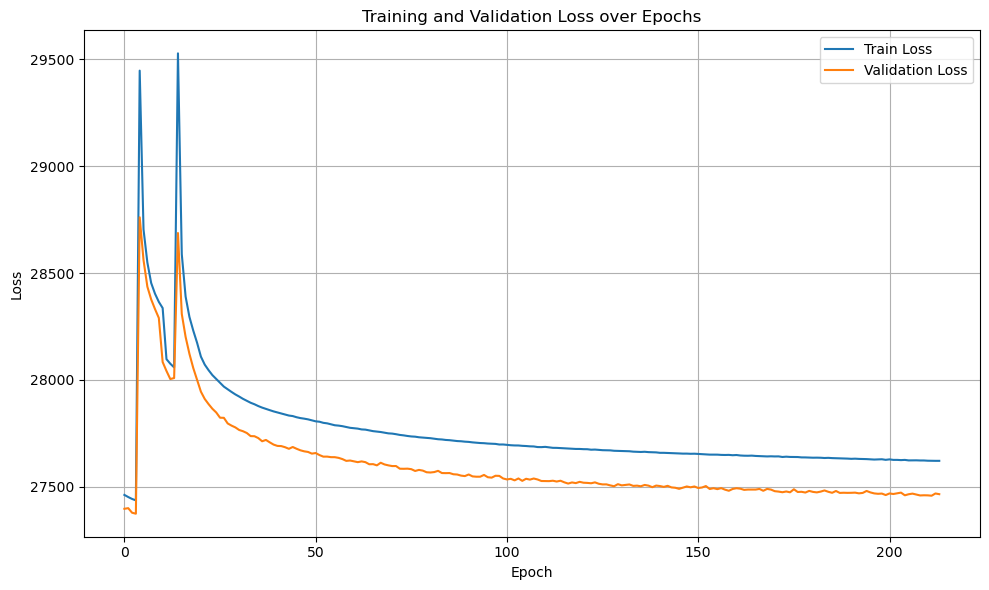

In [116]:

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluate the model

In [112]:

def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    all_recon = []
    all_original = []
    all_latent = []
    all_conditions = []
    
    with torch.no_grad():
        for x_batch, c_batch in tqdm(test_loader):
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)
            
            # Forward pass
            recon_x, mu, logvar = model(x_batch, c_batch)
            loss = loss_function(recon_x, x_batch, mu, logvar)
            total_loss += loss.item()
            
            # Store results
            all_recon.append(recon_x.cpu().numpy())
            all_original.append(x_batch.cpu().numpy())
            all_latent.append(mu.cpu().numpy())
            all_conditions.append(c_batch.cpu().numpy())
    
    # Concatenate all batches
    all_recon = np.concatenate(all_recon, axis=0)
    all_original = np.concatenate(all_original, axis=0)
    all_latent = np.concatenate(all_latent, axis=0)
    all_conditions = np.concatenate(all_conditions, axis=0)
    
    return {
        'total_loss': total_loss,
        'recon': all_recon,
        'original': all_original,
        'latent': all_latent,
        'conditions': all_conditions
    }

### Run evalutations on test set

In [113]:

# Run evaluation
eval_results = evaluate_model(model, test_loader, device)
print(f"Test Loss: {eval_results['total_loss']:.2f}")

# Calculate reconstruction metrics
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R2 for each gene
mse_per_gene = mean_squared_error(eval_results['original'], eval_results['recon'], multioutput='raw_values')
r2_per_gene = r2_score(eval_results['original'], eval_results['recon'], multioutput='raw_values')

print(f"Average MSE per gene: {np.mean(mse_per_gene):.4f}")
print(f"Average R2 per gene: {np.mean(r2_per_gene):.4f}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 138.23it/s]


Test Loss: 21569513.14
Average MSE per gene: 0.1006
Average R2 per gene: 0.3275


### Vizualise the results

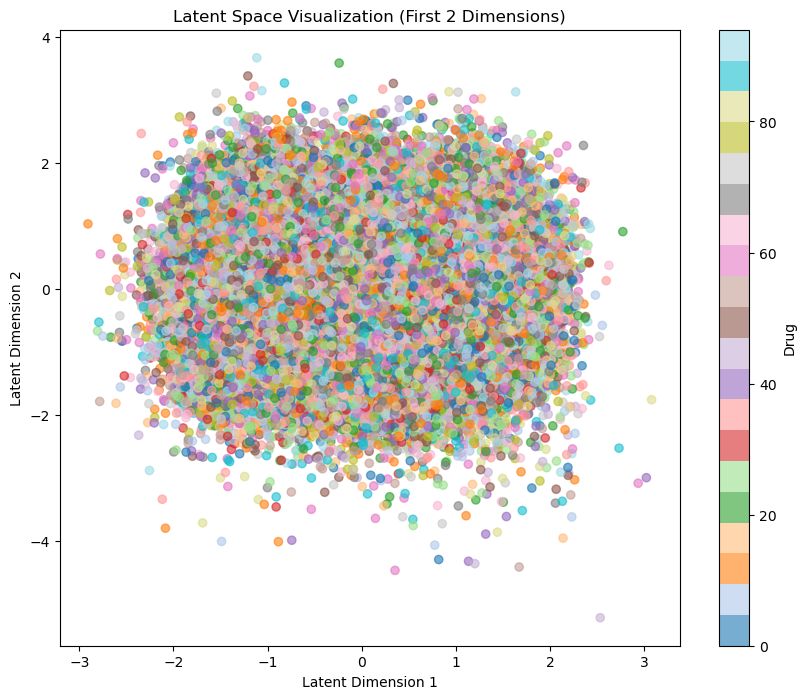

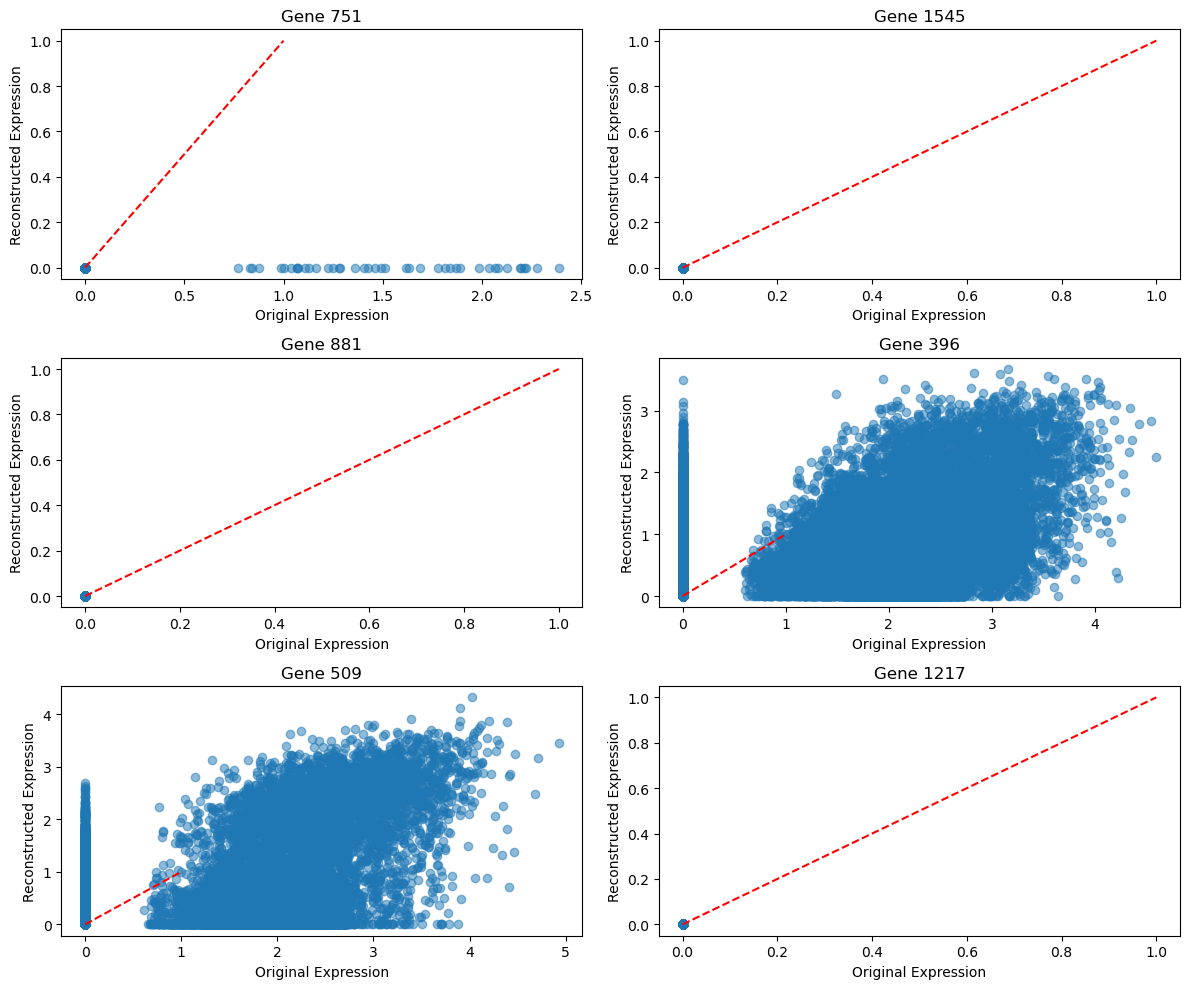

In [121]:


# Get the drug indices from the conditions
drug_indices = np.argmax(eval_results['conditions'][:, :len(adata_test.obs['drug'].unique())], axis=1)
drugs = adata_test.obs['drug'].unique()[drug_indices]

# Plot first two dimensions of latent space colored by drug
plt.figure(figsize=(10, 8))
scatter = plt.scatter(eval_results['latent'][:, 0], 
                     eval_results['latent'][:, 1], 
                     c=drug_indices, 
                     cmap='tab20',
                     alpha=0.6)
plt.title('Latent Space Visualization (First 2 Dimensions)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Drug')
plt.show()

# Plot reconstruction vs original for a few random genes
n_genes_to_plot = 6
np.random.seed(41)
random_genes = np.random.choice(eval_results['original'].shape[1], n_genes_to_plot, replace=False)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, gene_idx in enumerate(random_genes):
    axes[idx].scatter(eval_results['original'][:, gene_idx], 
                     eval_results['recon'][:, gene_idx], 
                     alpha=0.5)
    axes[idx].plot([0, 1], [0, 1], 'r--')  # Diagonal line
    axes[idx].set_xlabel('Original Expression')
    axes[idx].set_ylabel('Reconstructed Expression')
    axes[idx].set_title(f'Gene {gene_idx}')

plt.tight_layout()
plt.show()

### Plot top expressed genes

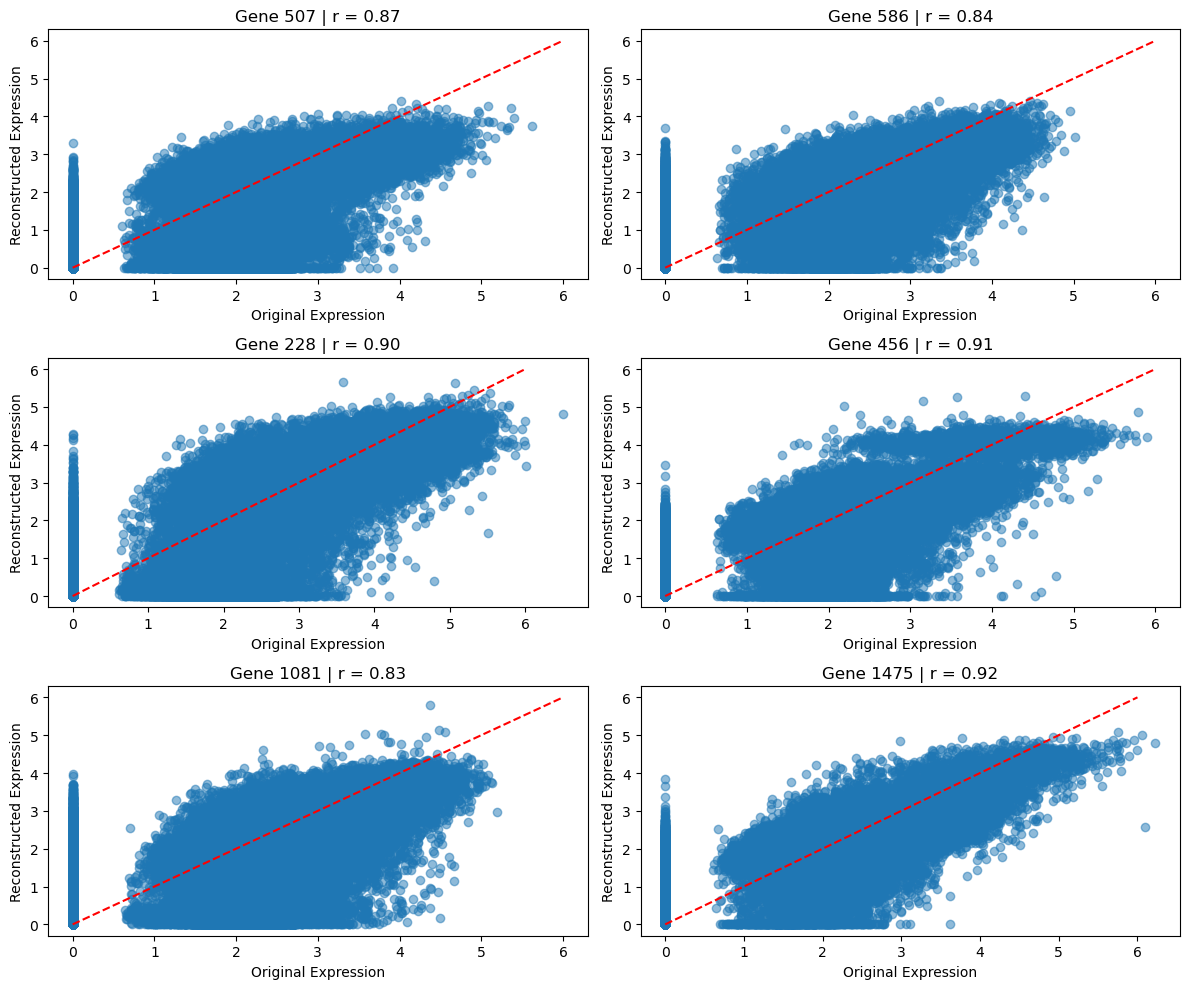

In [127]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Compute mean expression across cells for each gene
mean_expression = eval_results['original'].mean(axis=0)  # shape: (n_genes,)

# Select top n most expressed genes
n_genes_to_plot = 6
top_gene_indices = np.argsort(mean_expression)[-n_genes_to_plot:]

# Plot top expressed genes with correlation
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, gene_idx in enumerate(top_gene_indices):
    original_vals = eval_results['original'][:, gene_idx]
    recon_vals = eval_results['recon'][:, gene_idx]
    
    # Compute Pearson correlation
    corr, _ = pearsonr(original_vals, recon_vals)
    
    axes[idx].scatter(original_vals, recon_vals, alpha=0.5)
    axes[idx].plot([0, 6], [0, 6], 'r--')  # Diagonal line
    axes[idx].set_xlabel('Original Expression')
    axes[idx].set_ylabel('Reconstructed Expression')
    axes[idx].set_title(f'Gene {gene_idx} | r = {corr:.2f}')

plt.tight_layout()
plt.show()
